## Temporal distribution of data for the three water masses seperated by region of CCS

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from shapely.geometry import LineString, Point, MultiPoint, GeometryCollection, MultiLineString
from shapely.ops import unary_union

from pyproj import Geod
from cartopy.feature import NaturalEarthFeature

IOPATH = '/ocean/ghoeven/MOAD/Data/PNWCurrent_obs.csv'

## Loading Data

In [2]:
obs = pd.read_csv(IOPATH)
obs

,Unnamed: 0.1,Unnamed: 0,time,longitude (degrees_east),latitude (degrees_north),depth (m),pressure (dbar),temperature (degC),salinity (g kg-1),DO (umol kg-1),...,spice,current,geometry,location,month,year,salinity (psu),density (kg m-3),is_offshore100,TA-DIC (uM)
0,0,1271,1933-07-25 00:00:00+00:00,-126.76,49.34,1.0,1.008587,NaN,32.070847,NaN,...,NaN,Shelf_Current,POINT (-126.76 49.34),shelf,7,1933,31.920329,NaN,False,NaN
1,1,1272,1933-07-25 00:00:00+00:00,-126.76,49.34,2.0,2.017180,NaN,32.090943,NaN,...,NaN,Shelf_Current,POINT (-126.76 49.34),shelf,7,1933,31.940330,NaN,False,NaN
2,2,1273,1933-07-25 00:00:00+00:00,-126.76,49.34,4.0,4.034378,NaN,32.090906,NaN,...,NaN,Shelf_Current,POINT (-126.76 49.34),shelf,7,1933,31.940294,NaN,False,NaN
3,3,1274,1933-07-25 00:00:00+00:00,-126.76,49.34,6.0,6.051598,NaN,32.090870,NaN,...,NaN,Shelf_Current,POINT (-126.76 49.34),shelf,7,1933,31.940258,NaN,False,NaN
4,4,1275,1933-07-25 00:00:00+00:00,-126.76,49.34,10.0,10.086095,NaN,32.181305,NaN,...,NaN,Shelf_Current,POINT (-126.76 49.34),shelf,7,1933,32.030268,NaN,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
937227,937227,2657130,2024-11-18 00:00:00+00:00,-124.95,44.38,0.0,0.000000,12.713836,32.386146,312.025459,...,-0.251376,NaN,POINT (-124.95 44.38),slope,11,2024,32.234148,24.307180,False,NaN
937228,937228,2657131,2024-11-18 00:00:00+00:00,-124.94,44.36,0.0,0.000000,12.712860,32.386131,NaN,...,-0.251582,NaN,POINT (-124.94 44.36),slope,11,2024,32.234133,24.307357,False,NaN
937229,937229,2657133,2024-11-18 00:00:00+00:00,-124.57,46.99,0.0,0.000000,10.586080,32.728763,202.661375,...,-0.405998,Shelf_Current,POINT (-124.57 46.99),shelf,11,2024,32.575157,24.960321,False,NaN
937230,937230,2657134,2024-11-18 00:00:00+00:00,-124.56,46.99,0.0,0.000000,12.215222,32.245641,308.384776,...,-0.452611,Shelf_Current,POINT (-124.56 46.99),shelf,11,2024,32.094303,24.293613,False,NaN


## Helper Functions

In [3]:
# From Becca for 
def isobath_lon(lat):
    """
    Return the easternmost longitude of the 2000 m isobath at this latitude.
    Handles Point, MultiPoint, LineString, MultiLineString, and GeometryCollection.
    """
    # build a horizontal scan line across your plotting lon‐range
    scan = LineString([ (xlim[0], lat), (xlim[1], lat) ])
    result = iso2k.intersection(scan)

    # collect candidate points
    pts = []
    if isinstance(result, Point):
        pts = [result]
    elif isinstance(result, MultiPoint):
        pts = list(result.geoms)
    elif isinstance(result, LineString):
        # take both end‐points of the overlap segment
        pts = [Point(c) for c in result.coords]
    elif isinstance(result, MultiLineString):
        # flatten all the segment end‐points
        for seg in result.geoms:
            pts.extend(Point(c) for c in seg.coords)
    elif isinstance(result, GeometryCollection):
        for geom in result.geoms:
            if isinstance(geom, Point):
                pts.append(geom)
            elif isinstance(geom, LineString):
                pts.extend(Point(c) for c in geom.coords)
            elif isinstance(geom, MultiLineString):
                for seg in geom.geoms:
                    pts.extend(Point(c) for c in seg.coords)
    else:
        raise RuntimeError(f"Unexpected intersection type: {type(result)}")

    # filter to the Pacific shelf‐break window and pick the easternmost
    pts = [p for p in pts if -140 < p.x < -115]
    if not pts:
        raise ValueError(f"No 2 000 m isobath found at lat={lat}")
    return max(p.x for p in pts)


def along_track_distance_array(lon_pts, lat_pts):
    """
    Compute signed along-track distances (in km) to both the NS and EW tracks
    for arrays of input points. EW distances are NaN outside of [46.5, 50.5]°N.

    Parameters
    ----------
    lon_pts, lat_pts : array-like
        Arrays of input longitude and latitude points.

    Defined earlier in code
    -----------------------
    lons_NS, lats_NS, d_NS : array-like
        North-south track coordinates and distances.
    lons_EW, lats_EW, d_EW : array-like
        East-west track coordinates and distances.
    geod : pyproj.Geod
        Geodetic calculator.

    Returns
    -------
    d_NS_out : np.ndarray
        Along-track distances (km) to NS track.
    d_EW_out : np.ndarray
        Along-track distances (km) to EW track, NaN outside 46.5–50.5°N.
    """
    lon_pts = np.asarray(lon_pts)
    lat_pts = np.asarray(lat_pts)

    d_NS_out = np.empty_like(lon_pts, dtype=float)
    d_EW_out = np.empty_like(lon_pts, dtype=float)

    ns_max_distance_km = 600
    for i, (lon, lat) in enumerate(zip(lon_pts, lat_pts)):
        # --- NS distance ---
        _, _, dist_NS = geod.inv(
            lons_NS, lats_NS,
            np.full_like(lons_NS, lon),
            np.full_like(lats_NS, lat)
        )
        idx_NS = np.argmin(dist_NS)
        if dist_NS[idx_NS] <= ns_max_distance_km * 1000:
            d_NS_out[i] = d_NS[idx_NS] / 1000.0
        else:
            d_NS_out[i] = np.nan

        # --- EW distance ---
        if 46.5 <= lat <= 50.5:
            _, _, dist_EW = geod.inv(
                lons_EW, lats_EW,
                np.full_like(lons_EW, lon),
                np.full_like(lats_EW, lat)
            )
            idx_EW = np.argmin(dist_EW)
            d_EW_out[i] = d_EW[idx_EW] / 1000.0
        else:
            d_EW_out[i] = np.nan

    return d_NS_out, d_EW_out



# Figures:

### All Observations Together

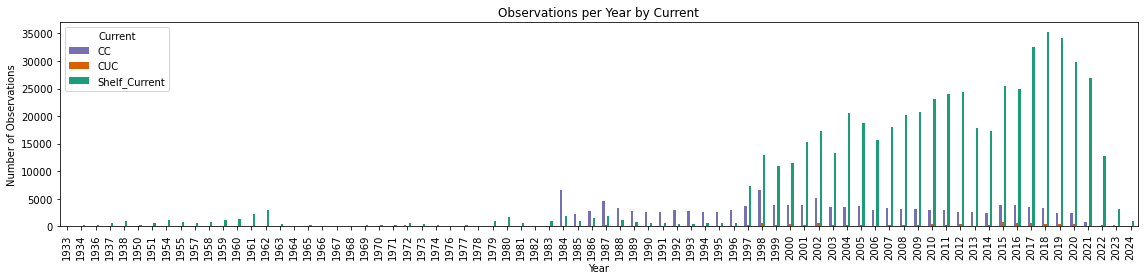

In [4]:
# Initial setup of all the data
obs_counts = obs.groupby(['year', 'current']).size().unstack(fill_value=0)

obs_counts = obs_counts.sort_index()

colors = {'CC': '#7570b3', 'CUC': '#d95f02', 'Shelf': '#1b9e77'}

fig, ax = plt.subplots(figsize=(16, 4))
obs_counts[['CC', 'CUC', 'Shelf_Current']].plot(kind='bar',ax=ax,color=[colors[col] for col in ['CC', 'CUC', 'Shelf']])

ax.set_xlabel('Year')
ax.set_ylabel('Number of Observations')
ax.set_title('Observations per Year by Current')
ax.legend(title='Current')
# ax.set_yscale('log')
plt.tight_layout()
plt.show()

In [5]:
# Sorting by region
ylim = [30,55]
xlim = [-145,-115]
# — PARAMETERS —
pivot_lat = 48.5             # switch-over latitude
offset_m = 50e3             # 100 km offshore
tick_km = 2000               # label every 2000 km
leg_samps = 80              # how many points along each leg

# geodesic helper
geod = Geod(ellps='WGS84')

# grab the 2 000 m isobath as a Shapely geometry
iso2k_feature = NaturalEarthFeature(
    category='physical',
    name='bathymetry_I_2000',
    scale='10m',
)
iso2k = unary_union(list(iso2k_feature.geometries()))
iso2k = iso2k.simplify(tolerance=0.8, preserve_topology=True)

# — 1) build the NS (coast-following) leg: from 52°N to 30°N —
lats_NS = np.linspace(57, 30, leg_samps)
lons_NS_coast = np.array([isobath_lon(lat) for lat in lats_NS])

# offset each point 50 km offshore (az=270°)
azs_NS = np.full_like(lons_NS_coast, 270.0)
lons_NS, lats_NS, _ = geod.fwd(lons_NS_coast, lats_NS, azs_NS, np.full(leg_samps, offset_m))

# compute cumulative distances along NS leg (pivot at 48.5N)
_, _, segd_NS = geod.inv(lons_NS[:-1], lats_NS[:-1], lons_NS[1:], lats_NS[1:])
d_NS = np.concatenate([[0], np.cumsum(segd_NS)])

# set 48.5°N as 0 km reference
idx_pivot_NS = np.argmin(np.abs(lats_NS - pivot_lat))
d_NS = d_NS - d_NS[idx_pivot_NS]

# — 2) build the EW leg along pivot_lat (westward from pivot point) —
pivot_lon_coast = isobath_lon(pivot_lat)
pivot_lon_off, pivot_lat_off, _ = geod.fwd(pivot_lon_coast, pivot_lat, 270, offset_m)

lons_EW = np.linspace(pivot_lon_off, xlim[0], leg_samps)
lats_EW = np.full_like(lons_EW, pivot_lat_off)

# compute distances from pivot (negative westward)
_, _, segd_EW = geod.inv(lons_EW[:-1], lats_EW[:-1], lons_EW[1:], lats_EW[1:])
d_EW = -np.concatenate([[0], np.cumsum(segd_EW)])

d_NS_out, d_EW_out = along_track_distance_array(obs['longitude (degrees_east)'], obs['latitude (degrees_north)'])

obs['NS_distance'] = d_NS_out


In [6]:
obs_northCCS = obs[obs['NS_distance'] <= 1000]
obs_centerCCS = obs[(obs['NS_distance'] <= 1750) & (obs['NS_distance'] >= 1000)]
obs_southCCS = obs[obs['NS_distance'] >= 1750]


### Northern CCS

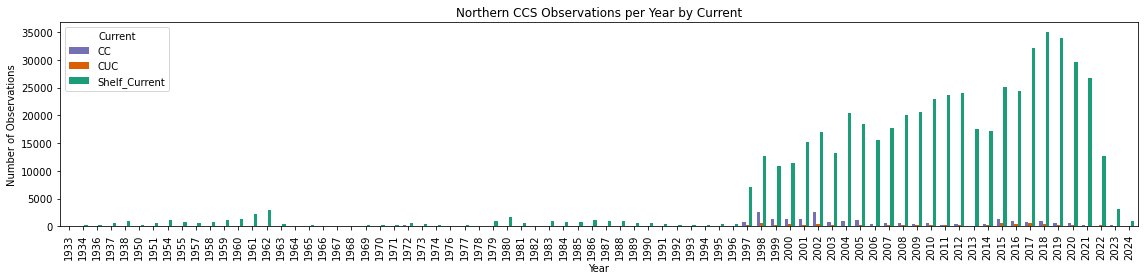

In [7]:
# Northern CCS observations
obs_counts = obs_northCCS.groupby(['year', 'current']).size().unstack(fill_value=0)

obs_counts = obs_counts.sort_index()

colors = {'CC': '#7570b3', 'CUC': '#d95f02', 'Shelf': '#1b9e77'}

fig, ax = plt.subplots(figsize=(16, 4))
obs_counts[['CC', 'CUC', 'Shelf_Current']].plot(kind='bar',ax=ax,color=[colors[col] for col in ['CC', 'CUC', 'Shelf']], width=0.7)

ax.set_xlabel('Year')
ax.set_ylabel('Number of Observations')
ax.set_title('Northern CCS Observations per Year by Current')
ax.legend(title='Current')
# ax.set_yscale('log')
plt.tight_layout()
plt.show()

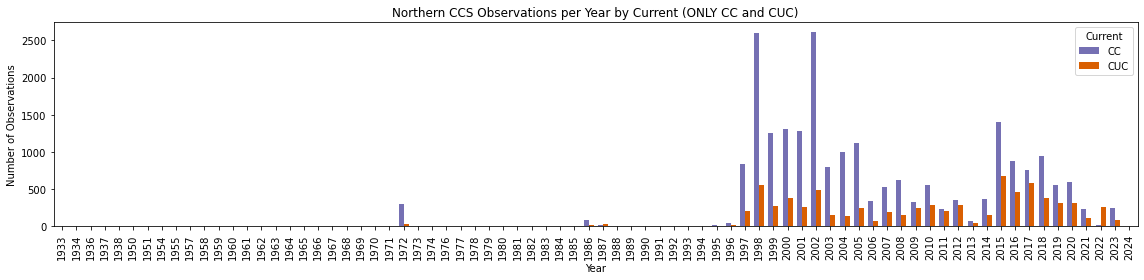

In [8]:
# Northern CCS observations
obs_counts = obs_northCCS.groupby(['year', 'current']).size().unstack(fill_value=0)

obs_counts = obs_counts.sort_index()

colors = {'CC': '#7570b3', 'CUC': '#d95f02'}

fig, ax = plt.subplots(figsize=(16, 4))
obs_counts[['CC', 'CUC']].plot(kind='bar',ax=ax,color=[colors[col] for col in ['CC', 'CUC']], width=0.7)

ax.set_xlabel('Year')
ax.set_ylabel('Number of Observations')
ax.set_title('Northern CCS Observations per Year by Current (ONLY CC and CUC)')
ax.legend(title='Current')
plt.tight_layout()
plt.show()

### Central CCS

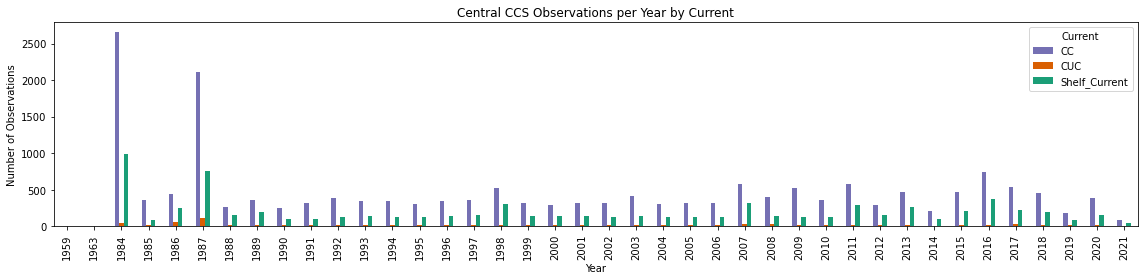

In [9]:
# Central CCS observations
obs_counts = obs_centerCCS.groupby(['year', 'current']).size().unstack(fill_value=0)

obs_counts = obs_counts.sort_index()

colors = {'CC': '#7570b3', 'CUC': '#d95f02', 'Shelf': '#1b9e77'}

fig, ax = plt.subplots(figsize=(16, 4))
obs_counts[['CC', 'CUC', 'Shelf_Current']].plot(kind='bar',ax=ax,color=[colors[col] for col in ['CC', 'CUC', 'Shelf']])

ax.set_xlabel('Year')
ax.set_ylabel('Number of Observations')
ax.set_title('Central CCS Observations per Year by Current')
ax.legend(title='Current', loc='upper right')
# ax.set_yscale('log')
plt.tight_layout()
plt.show()

### Southern CCS

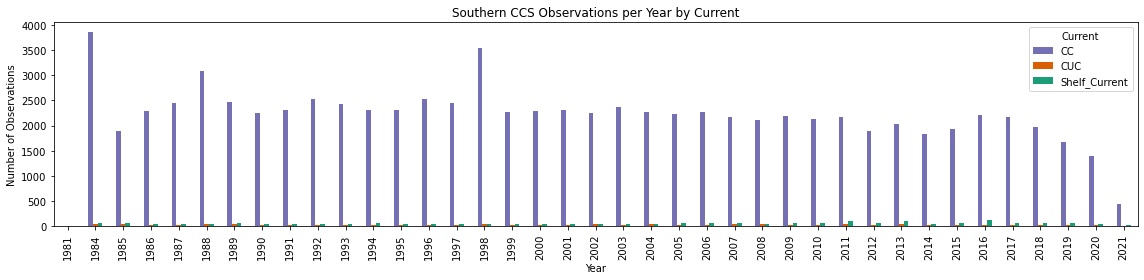

In [10]:
# Southern CCS observations
obs_counts = obs_southCCS.groupby(['year', 'current']).size().unstack(fill_value=0)

obs_counts = obs_counts.sort_index()

colors = {'CC': '#7570b3', 'CUC': '#d95f02', 'Shelf': '#1b9e77'}

fig, ax = plt.subplots(figsize=(16, 4))
obs_counts[['CC', 'CUC', 'Shelf_Current']].plot(kind='bar',ax=ax,color=[colors[col] for col in ['CC', 'CUC', 'Shelf']])

ax.set_xlabel('Year')
ax.set_ylabel('Number of Observations')
ax.set_title('Southern CCS Observations per Year by Current')
ax.legend(title='Current')
# ax.set_yscale('log')
plt.tight_layout()
plt.show()